<a href="https://www.kaggle.com/concaption/dogs-v-cats-88-no-transfer-learning?scriptVersionId=85041819" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://colab.research.google.com/github/concaption/cats-vs-dogs/blob/main/cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load data

In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
from zipfile import ZipFile as unzip
import matplotlib.pyplot as plt
!pip install gdown
import gdown

  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=93290ce013c558103d11ce155f044a7b8d01ba8365e44bdd782407cc56ffdc5c
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
Successfully built gdown


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [3]:
input_dir = '../input/dogs-vs-cats/'
for _ , _  , filenames in os.walk(input_dir):
    for filename in filenames:
        if filename[-3:]=='zip':
            file = unzip(os.path.join(input_dir,filename),'r')
            file.extractall()
            file.close()

In [4]:
print("Number of train images: " , len(os.listdir('./train')) )
print("Number of test images: "  , len(os.listdir('./test1')) )

Number of train images:  25000
Number of test images:  12500


In [5]:
no_of_cats = len([files for files in os.listdir('./train') if 'cat' in files])
no_of_dogs = len([files for files in os.listdir('./train') if 'dog' in files])
print("Cat images in train dataset: ",  no_of_cats)
print("Dog images in train dataset: ", no_of_dogs)
if no_of_cats==no_of_dogs:
  total_images = no_of_cats
  print('Balanced dataset')

Cat images in train dataset:  12500
Dog images in train dataset:  12500
Balanced dataset


In [6]:
base_dir = 'data/'
dirs = ['train','val','test']
sub_dirs = ['cats','dogs']
for dir in dirs:
  dir =  os.path.join(base_dir, dir)
  os.makedirs(dir,exist_ok=True)
  for sub_dir in sub_dirs:
    sub_dir = os.path.join(dir, sub_dir)
    os.makedirs(sub_dir,exist_ok=True)

In [7]:
split = {'train': 0.7,
         'val': 0.3}

for dir in dirs[:2]:
    print(int(split[dir]*total_images))

8750
3750


In [8]:
split_size = 0.7

split = {'train': (0,int(split_size*total_images)),
         'val': (int(split_size*total_images),total_images)}

for obj in sub_dirs:
  for dir in dirs[:2]:
    files = ['{}.{}.jpg'.format(obj[:-1],i) for i in range(*split[dir])]
    for filename in files:
      src = os.path.join('./train', filename)
      dst = os.path.join(base_dir,dir,obj,filename)
      shutil.copyfile(src,dst)
print("Train validation split completed.")

Train validation split completed.


In [9]:
#os.makedirs(os.path.join(base_dir,'test','test_images',),exist_ok=True)
#for filename in ['{}.jpg'.format(i) for i in range(1,1+len(os.listdir('test1')))]:
#    src = os.path.join('./test1', filename)
#    dst = os.path.join(base_dir,'test','test_images',filename)
#    shutil.copyfile(src,dst)
#print("Test files moved.")

In [10]:
#shutil.rmtree('train')
#shutil.rmtree('test1')

In [11]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [12]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.1990.jpg', 'cat.1032.jpg', 'cat.4331.jpg', 'cat.6997.jpg', 'cat.1350.jpg', 'cat.755.jpg', 'cat.7954.jpg', 'cat.2438.jpg', 'cat.670.jpg', 'cat.6081.jpg']
['dog.8077.jpg', 'dog.2116.jpg', 'dog.8312.jpg', 'dog.2442.jpg', 'dog.361.jpg', 'dog.6513.jpg', 'dog.8738.jpg', 'dog.3084.jpg', 'dog.7037.jpg', 'dog.2321.jpg']


In [13]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 8750
total training dog images : 8750
total validation cat images : 3750
total validation dog images : 3750


In [14]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

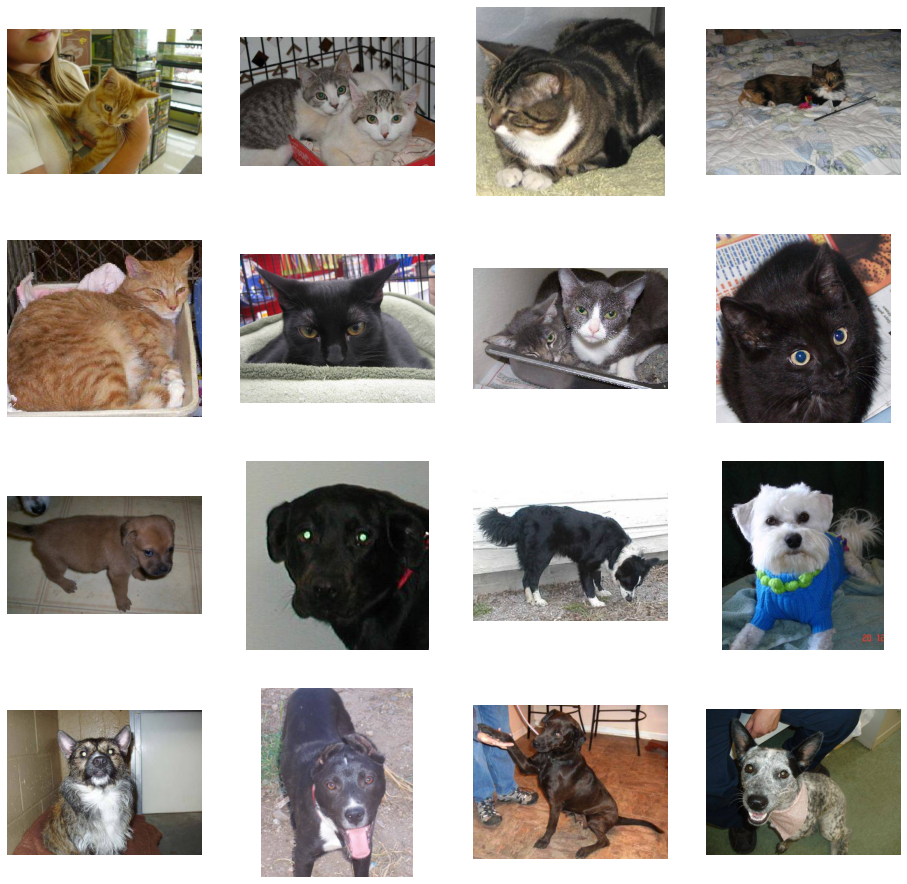

In [15]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [16]:
model = tf.keras.models.Sequential([
        Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)),
        Conv2D(64,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(4,4),

        Conv2D(128,kernel_size=(3,3),activation='relu'),    
        Conv2D(64,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(4,4),
    
        Flatten(),    
        Dense(512,activation='relu') ,
        Dropout(rate=0.3),
        Dense(1, activation='sigmoid'),    
        ])

2022-01-12 08:51:43.123668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 08:51:43.222532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 08:51:43.223198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 08:51:43.224310: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 128)     3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      73792     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [18]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [19]:
datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = datagen.flow_from_directory(train_dir,
                                              batch_size=20,
                                              class_mode ='binary',
                                              target_size=(150,150))
validation_generator = datagen.flow_from_directory(validation_dir,
                                                   batch_size=20,
                                                   class_mode='binary',
                                                   target_size = (150,150))

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


(20, 150, 150, 3)
0.0


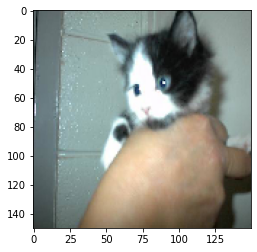

(20, 150, 150, 3)
1.0


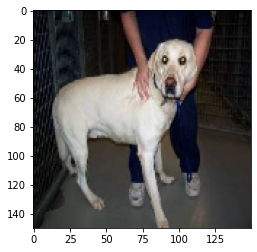

(20, 150, 150, 3)
0.0


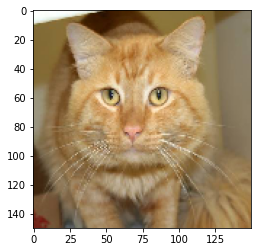

(20, 150, 150, 3)
1.0


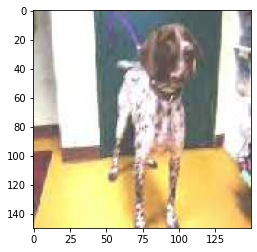

(20, 150, 150, 3)
1.0


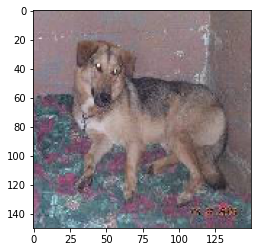

In [20]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    print(label[0])
    plt.imshow(img[0])
    plt.show()

In [21]:
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='saved/model.{epoch:02d}-{val_loss:.2f}.h5',save_weights_only=False),
    tf.keras.callbacks.TensorBoard(log_dir='saved/logs'),
]

2022-01-12 08:51:50.417794: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-12 08:51:50.417852: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-12 08:51:50.420075: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-01-12 08:51:50.639614: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-12 08:51:50.639787: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [22]:
histroy = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_steps = 50,
                    verbose=2,
                   callbacks=[my_callbacks])

2022-01-12 08:51:51.041006: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-01-12 08:51:52.629992: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-01-12 08:51:58.852824: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-12 08:51:58.852874: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-12 08:51:59.156475: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-12 08:51:59.157396: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-01-12 08:51:59.288081: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 251 callback api events and 250 activity events. 
2022-01-12 08:51:59.296087: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-12 08:51:59.312667: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: saved/logs/train/plugins/profile/2022_01_12_08_

100/100 - 19s - loss: 0.7564 - accuracy: 0.5120 - val_loss: 0.6869 - val_accuracy: 0.5460
Epoch 2/50
100/100 - 8s - loss: 0.7027 - accuracy: 0.5655 - val_loss: 0.6678 - val_accuracy: 0.6170
Epoch 3/50
100/100 - 11s - loss: 0.6855 - accuracy: 0.6140 - val_loss: 0.6374 - val_accuracy: 0.6330
Epoch 4/50
100/100 - 11s - loss: 0.6331 - accuracy: 0.6525 - val_loss: 0.5984 - val_accuracy: 0.6770
Epoch 5/50
100/100 - 11s - loss: 0.5894 - accuracy: 0.6875 - val_loss: 0.5588 - val_accuracy: 0.7280
Epoch 6/50
100/100 - 8s - loss: 0.5734 - accuracy: 0.7200 - val_loss: 0.5312 - val_accuracy: 0.7270
Epoch 7/50
100/100 - 9s - loss: 0.5785 - accuracy: 0.7165 - val_loss: 0.5066 - val_accuracy: 0.7380
Epoch 8/50
100/100 - 9s - loss: 0.5219 - accuracy: 0.7440 - val_loss: 0.4891 - val_accuracy: 0.7580
Epoch 9/50
100/100 - 9s - loss: 0.5211 - accuracy: 0.7535 - val_loss: 0.4548 - val_accuracy: 0.7890
Epoch 10/50
100/100 - 11s - loss: 0.4929 - accuracy: 0.7610 - val_loss: 0.4819 - val_accuracy: 0.7840
Epoch

In [23]:
# save weights
model.save('/saved/dogs_vs_cats_model.h5')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


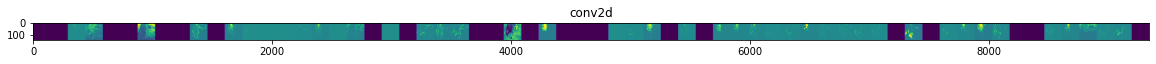

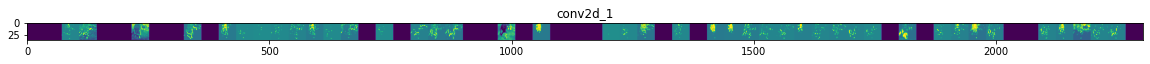

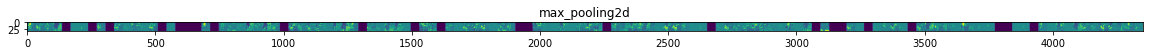

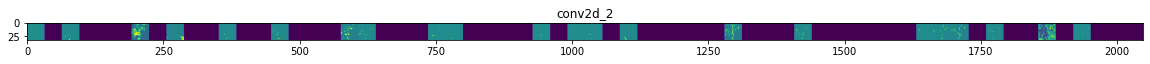

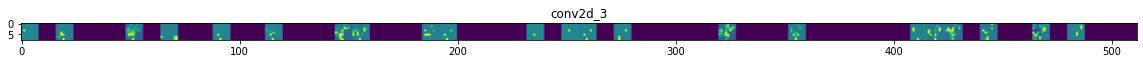

In [24]:
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

Text(0.5, 1.0, 'Training and validation loss')

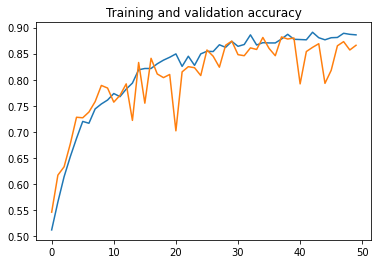

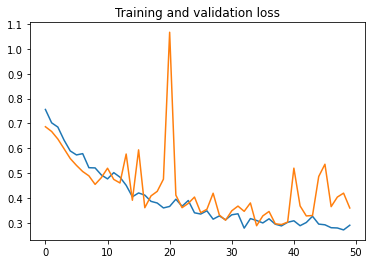

In [25]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = model.history.history[     'accuracy' ]
val_acc  = model.history.history[ 'val_accuracy' ]
loss     = model.history.history[    'loss' ]
val_loss = model.history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [26]:
saved_model = tf.keras.models.load_model('/saved/dogs_vs_cats_model.h5')

In [27]:
# for filename in ['{}.jpg'.format(i) for i in range(1,1+len(os.listdir('test1')))]:
#    path = os.path.join('test1',filename)
#   img=image.load_img(path, target_size=(150, 150))
#   x=image.img_to_array(img)
#   x=np.expand_dims(x, axis=0)
#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=10)

In [28]:
# test_generator = datagen.flow_from_directory('./data/test',
#                                               batch_size=20,
#                                               class_mode =None,
#                                               target_size=(150,150))
# predictions = model.predict(test_generator)
# predictions[:10]
# mot going use this because the predcitions are random. Pictures are shuffled.
# A better way is to first load the test file into a dataframe and then use flow_from_dataframe method.
# Need tto implement flow_from_dataframe.

In [29]:
predictions = []
for filename in ['{}.jpg'.format(i) for i in range(1,1+len(os.listdir('test1')))]:
  img = load_img(os.path.join('test1',filename), target_size=(150, 150))
  x = img_to_array(img)                         # Numpy array with shape (150, 150, 3)
  x = x.reshape((1,) + x.shape)                 # Numpy array with shape (1, 150, 150, 3)
  x /= 255.0
  y_hat= model.predict(x)
  predictions.append(y_hat)

In [30]:
pred=np.asarray(predictions)
pred=np.squeeze(pred)
for i, y_hat in enumerate(pred):
    pred[i] = 1 if y_hat>0.5 else 0

In [31]:
index_values = [i+1 for i in range(len(pred))]
column_label = ['label']

# creating the dataframe
df = pd.DataFrame(data = pred, 
                  index = index_values, 
                  columns = column_label)

In [32]:
df.to_csv('submission.csv', index_label='id')